# PID Control Testing for Maglev Pod

This notebook provides a feedforward + PID control interface for the `LevPodEnv` simulation environment.

## Control Architecture
- **Feedforward**: `MaglevPredictor` estimates the equilibrium PWM needed to hover at the current gap height
- **Height PID**: Corrects residual gap error → additive PWM correction for all coils
- **Roll PID**: Corrects roll angle → differential left/right adjustment
- **Pitch PID**: Corrects pitch angle → differential front/back adjustment

The outputs combine: `coil_pwm = feedforward + height_correction ± roll_adjustment ± pitch_adjustment`

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from lev_pod_env import LevPodEnv, TARGET_GAP
from pid_controller import PIDController, DEFAULT_GAINS
from pid_simulation import run_pid_simulation, feedforward_pwm, build_feedforward_lut

# Set plot style for better aesthetics
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print(f"Target Gap Height: {TARGET_GAP * 1000:.2f} mm")

Target Gap Height: 16.49 mm


---
## Load PID gains (JSON or defaults)

Try to load `pid_best_params.json` (saved by Optuna in this folder). If missing, use `DEFAULT_GAINS`. You can override any value in the **PID Gains Configuration** cell below.

In [38]:
import os
import json

try:
    import optuna_pid_tune as _optuna_tune
    _best_path = os.path.join(os.path.dirname(os.path.abspath(_optuna_tune.__file__)), "pid_best_params.json")
except Exception:
    _best_path = "pid_best_params.json"

if os.path.isfile(_best_path):
    with open(_best_path) as f:
        _best = json.load(f)
    HEIGHT_KP = _best["height_kp"]
    HEIGHT_KI = _best["height_ki"]
    HEIGHT_KD = _best["height_kd"]
    ROLL_KP = _best["roll_kp"]
    ROLL_KI = _best["roll_ki"]
    ROLL_KD = _best["roll_kd"]
    PITCH_KP = _best["pitch_kp"]
    PITCH_KI = _best["pitch_ki"]
    PITCH_KD = _best["pitch_kd"]
    gains = dict(_best)
    print(f"Loaded PID gains from {_best_path}")
else:
    HEIGHT_KP = DEFAULT_GAINS["height_kp"]
    HEIGHT_KI = DEFAULT_GAINS["height_ki"]
    HEIGHT_KD = DEFAULT_GAINS["height_kd"]
    ROLL_KP = DEFAULT_GAINS["roll_kp"]
    ROLL_KI = DEFAULT_GAINS["roll_ki"]
    ROLL_KD = DEFAULT_GAINS["roll_kd"]
    PITCH_KP = DEFAULT_GAINS["pitch_kp"]
    PITCH_KI = DEFAULT_GAINS["pitch_ki"]
    PITCH_KD = DEFAULT_GAINS["pitch_kd"]
    gains = dict(DEFAULT_GAINS)
    print("Using DEFAULT_GAINS (no pid_best_params.json found). Run Optuna to save best params.")

Loaded PID gains from /Users/adipu/Documents/guadaloop_lev_control/RL Testing/pid_best_params.json


---
## PID Controller Class

In [39]:
# PID controller and default gains live in pid_controller.py (imported above).
# Override gains in the next cell; they are passed to run_pid_simulation via the gains dict.

---
## PID Gains Configuration (optional overrides)

Constants are already set above from `pid_best_params.json` or defaults. To **override**, uncomment and edit a line in the cell below (e.g. `HEIGHT_KP = 50.0`) and re-run that cell; then run the simulation.

In [40]:
# Optional manual overrides: set any constant below and re-run this cell to use it.
# Otherwise the values from the "Load PID gains" cell (JSON or DEFAULT_GAINS) are used.
# HEIGHT_KP = 50.0
# HEIGHT_KI = 5.0
# HEIGHT_KD = 10.0
# ROLL_KP = 2.0
# ROLL_KI = 0.5
# ROLL_KD = 0.5
# PITCH_KP = 2.0
# PITCH_KI = 0.5
# PITCH_KD = 0.5

# Build gains dict from current constants (used by run_pid_simulation)
gains = {
    "height_kp": HEIGHT_KP, "height_ki": HEIGHT_KI, "height_kd": HEIGHT_KD,
    "roll_kp": ROLL_KP, "roll_ki": ROLL_KI, "roll_kd": ROLL_KD,
    "pitch_kp": PITCH_KP, "pitch_ki": PITCH_KI, "pitch_kd": PITCH_KD,
}

print("PID Gains (used by simulation):")
print(f"  Height: Kp={HEIGHT_KP}, Ki={HEIGHT_KI}, Kd={HEIGHT_KD}")
print(f"  Roll:   Kp={ROLL_KP}, Ki={ROLL_KI}, Kd={ROLL_KD}")
print(f"  Pitch:  Kp={PITCH_KP}, Ki={PITCH_KI}, Kd={PITCH_KD}")

PID Gains (used by simulation):
  Height: Kp=80.05607483893696, Ki=0, Kd=7.09266287860531
  Roll:   Kp=-0.600856607986966, Ki=0, Kd=-0.1
  Pitch:  Kp=50.3415835489009, Ki=0.02319184022898008, Kd=0.017632648760979346


In [41]:
# ============================================================
#           FEEDFORWARD USING MAGLEV PREDICTOR
# ============================================================
# Builds gap → equilibrium PWM LUT in pid_simulation (used by run_pid_simulation).
build_feedforward_lut()
print(f"Feedforward LUT ready. At target gap ({TARGET_GAP*1000:.2f} mm): PWM = {feedforward_pwm(TARGET_GAP * 1000):.4f}")

Loading maglev model from /Users/adipu/Documents/guadaloop_lev_control/RL Testing/maglev_model.pkl...
Model loaded. Degree: 6
Force R2: 1.0000
Torque R2: 0.9999


/Users/adipu/Documents/guadaloop_lev_control/.venv/lib/python3.13/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator PolynomialFeatures from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/adipu/Documents/guadaloop_lev_control/.venv/lib/python3.13/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Feedforward LUT ready. At target gap (16.49 mm): PWM = -0.0000


---
## Simulation Runner

In [42]:
# run_pid_simulation is imported from pid_simulation (see imports).
# It accepts gains=... (dict with height_kp, height_ki, ...), plus initial_gap_mm, max_steps, etc.
# The gains dict is built in the "PID Gains Configuration" cell above.

---
## Plotting Functions

In [43]:
def plot_results(data: dict, title_suffix: str = ""):
    """
    Create aesthetic plots of simulation results.
    
    Args:
        data: Dictionary from run_pid_simulation()
        title_suffix: Optional suffix for plot titles
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'PID Control Performance{title_suffix}', fontsize=16, fontweight='bold', y=1.02)
    
    target_gap_mm = TARGET_GAP * 1000
    time = data['time']
    
    # Color palette
    colors = {
        'primary': '#2563eb',    # Blue
        'secondary': '#7c3aed',  # Purple
        'accent1': '#059669',    # Green
        'accent2': '#dc2626',    # Red
        'target': '#f59e0b',     # Orange
        'grid': '#e5e7eb'
    }
    
    # ========== Gap Height Plot ==========
    ax1 = axes[0, 0]
    ax1.plot(time, data['gap_avg'], color=colors['primary'], linewidth=2, label='Average Gap')
    ax1.plot(time, data['gap_front'], color=colors['secondary'], linewidth=1, alpha=0.6, label='Front Yoke')
    ax1.plot(time, data['gap_back'], color=colors['accent1'], linewidth=1, alpha=0.6, label='Back Yoke')
    ax1.axhline(y=target_gap_mm, color=colors['target'], linestyle='--', linewidth=2, label=f'Target ({target_gap_mm:.1f}mm)')
    
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Gap Height (mm)')
    ax1.set_title('Gap Height Over Time', fontweight='bold')
    ax1.legend(loc='best', framealpha=0.9)
    ax1.set_ylim([0, 20])
    ax1.grid(True, alpha=0.3)
    
    # Add settling info
    final_error = abs(data['gap_avg'][-1] - target_gap_mm)
    ax1.text(0.98, 0.02, f'Final error: {final_error:.2f}mm', 
             transform=ax1.transAxes, ha='right', va='bottom',
             fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # ========== Roll Angle Plot ==========
    ax2 = axes[0, 1]
    ax2.plot(time, data['roll_deg'], color=colors['primary'], linewidth=2)
    ax2.axhline(y=0, color=colors['target'], linestyle='--', linewidth=1.5, alpha=0.7)
    ax2.fill_between(time, data['roll_deg'], 0, alpha=0.2, color=colors['primary'])
    
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Roll Angle (degrees)')
    ax2.set_title('Roll Angle Over Time', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    ax2.set_ylim([-4, 4])
    
    # ========== Pitch Angle Plot ==========
    ax3 = axes[1, 0]
    ax3.plot(time, data['pitch_deg'], color=colors['secondary'], linewidth=2)
    ax3.axhline(y=0, color=colors['target'], linestyle='--', linewidth=1.5, alpha=0.7)
    ax3.fill_between(time, data['pitch_deg'], 0, alpha=0.2, color=colors['secondary'])
    
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Pitch Angle (degrees)')
    ax3.set_title('Pitch Angle Over Time', fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    ax3.set_ylim([-6, 6])
    
    # ========== Current Draw Plot ==========
    ax4 = axes[1, 1]
    ax4.plot(time, data['current_FL'], linewidth=1.5, label='Front Left', alpha=0.8)
    ax4.plot(time, data['current_FR'], linewidth=1.5, label='Front Right', alpha=0.8)
    ax4.plot(time, data['current_BL'], linewidth=1.5, label='Back Left', alpha=0.8)
    ax4.plot(time, data['current_BR'], linewidth=1.5, label='Back Right', alpha=0.8)
    ax4.plot(time, data['current_total'], color='black', linewidth=2, label='Total', linestyle='--')
    
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Current (A)')
    ax4.set_title('Coil Current Draw Over Time', fontweight='bold')
    ax4.legend(loc='best', framealpha=0.9, ncol=2)
    ax4.grid(True, alpha=0.3)
    
    # Add average power info
    avg_total_current = np.mean(data['current_total'])
    ax4.text(0.98, 0.98, f'Avg total: {avg_total_current:.2f}A', 
             transform=ax4.transAxes, ha='right', va='top',
             fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return fig


def show_current_slice(data: dict, t_start: float, t_end: float):
    """
    Plot coil current draw over a time slice (same as bottom-right graph in plot_results()).

    Args:
        data: Dictionary from run_pid_simulation()
        t_start: Start time in seconds (inclusive)
        t_end: End time in seconds (inclusive)
    """
    time = np.asarray(data['time'])
    mask = (time >= t_start) & (time <= t_end)
    if not np.any(mask):
        print(f'No data in range [{t_start}, {t_end}] s.')
        return
    t = time[mask]
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(t, np.asarray(data['current_FL'])[mask], linewidth=1.5, label='Front Left', alpha=0.8)
    ax.plot(t, np.asarray(data['current_FR'])[mask], linewidth=1.5, label='Front Right', alpha=0.8)
    ax.plot(t, np.asarray(data['current_BL'])[mask], linewidth=1.5, label='Back Left', alpha=0.8)
    ax.plot(t, np.asarray(data['current_BR'])[mask], linewidth=1.5, label='Back Right', alpha=0.8)
    ax.plot(t, np.asarray(data['current_total'])[mask], color='black', linewidth=2, label='Total', linestyle='--')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Current (A)')
    ax.set_title(f'Coil Current Draw ({t_start}–{t_end} s)', fontweight='bold')
    ax.legend(loc='best', framealpha=0.9, ncol=2)
    ax.grid(True, alpha=0.3)
    avg_total = np.mean(np.asarray(data['current_total'])[mask])
    ax.text(0.98, 0.98, f'Avg total: {avg_total:.2f}A', transform=ax.transAxes, ha='right', va='top',
             fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plt.tight_layout()
    plt.show()
    return fig

In [44]:
def plot_control_signals(data: dict):
    """
    Plot the PWM control signals sent to each coil.
    
    Args:
        data: Dictionary from run_pid_simulation()
    """
    fig, ax = plt.subplots(figsize=(12, 5))
    
    time = data['time']
    
    ax.plot(time, data['pwm_FL'], label='Front Left', linewidth=1.5, alpha=0.8)
    ax.plot(time, data['pwm_FR'], label='Front Right', linewidth=1.5, alpha=0.8)
    ax.plot(time, data['pwm_BL'], label='Back Left', linewidth=1.5, alpha=0.8)
    ax.plot(time, data['pwm_BR'], label='Back Right', linewidth=1.5, alpha=0.8)
    
    if 'ff_pwm' in data and len(data.get('ff_pwm', [])) > 0:
        ff = data['ff_pwm'] if isinstance(data['ff_pwm'], np.ndarray) else np.array(data['ff_pwm'])
        ax.plot(time, ff, label='Feedforward', color='black', linewidth=2, linestyle='-.', alpha=0.7)
    
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
    ax.axhline(y=1, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Saturation')
    ax.axhline(y=-1, color='red', linestyle='--', linewidth=1, alpha=0.5)
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('PWM Duty Cycle')
    ax.set_title('Control Signals (PWM)', fontsize=14, fontweight='bold')
    ax.legend(loc='best', framealpha=0.9)
    ax.set_ylim([-1.2, 1.2])
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

---
## Run Simulation

**Configure the simulation parameters below and run the cell.**

In [45]:
# ============================================================
#               SIMULATION PARAMETERS
# ============================================================

INITIAL_GAP_MM = 14.0     # Starting gap height (mm). Target is ~16.49mm
MAX_STEPS = 10000          # Simulation steps (240 steps = 1 second)
USE_GUI = False           # PyBullet GUI often hangs in notebooks; keep False. Use recording instead.
USE_FEEDFORWARD = True    # Use MaglevPredictor feedforward for base PWM

# Recording (headless: no GUI window; files saved to RECORD_DIR)
RECORD_VIDEO = True      # Set True to save MP4 of each run (e.g. recordings/sim_YYYYMMDD_HHMMSS.mp4)
RECORD_TELEMETRY = False  # Set True to save 4-panel telemetry PNG per run
RECORD_DIR = "recordings" # Output folder for video and telemetry (created if missing)

# Impulse disturbance (one-time force at a specific step)
DISTURBANCE_STEP = 5000   # Step at which to apply impulse (e.g., 500). None = disabled
DISTURBANCE_FORCE = 8   # Impulse force in Newtons (positive = upward push)

# Stochastic disturbance (continuous random noise each step)
DISTURBANCE_FORCE_STD = 0.8  # Std dev of random force noise (Newtons). 0 = disabled

# ============================================================

# Run simulation (gains from "PID Gains Configuration" cell)
results = run_pid_simulation(
    initial_gap_mm=INITIAL_GAP_MM,
    max_steps=MAX_STEPS,
    use_gui=USE_GUI,
    disturbance_step=DISTURBANCE_STEP,
    disturbance_force=DISTURBANCE_FORCE,
    disturbance_force_std=DISTURBANCE_FORCE_STD,
    use_feedforward=USE_FEEDFORWARD,
    record_video=RECORD_VIDEO,
    record_telemetry=RECORD_TELEMETRY,
    record_dir=RECORD_DIR,
    gains=gains,
    verbose=True
)

Loading maglev model from /Users/adipu/Documents/guadaloop_lev_control/RL Testing/maglev_model.pkl...
Model loaded. Degree: 6
Force R2: 1.0000
Torque R2: 0.9999
Starting simulation: initial_gap=14.0mm, target=16.49mm
  Impulse disturbance: 8N at step 5000
  Stochastic noise: std=0.8N
  Feedforward: enabled
  Recording: video=True, telemetry=False → recordings/
  Applied 8N impulse and 4.00 N·m torque at step 5000
Video saved: recordings/sim_20260221_225018.mp4 (2500 frames, 60fps)
Simulation complete: 10000 steps, 41.66s
  Final gap: 16.55mm (target: 16.49mm)
  Final roll: 0.137°, pitch: 0.011°


In [46]:
print(results)

{'time': array([0.00000000e+00, 4.16666667e-03, 8.33333333e-03, ...,
       4.16541667e+01, 4.16583333e+01, 4.16625000e+01], shape=(10000,)), 'gap_front': array([14.        , 14.03629254, 14.06206169, ..., 16.51789156,
       16.5189227 , 16.52334894], shape=(10000,)), 'gap_back': array([14.        , 14.03557628, 14.06362381, ..., 16.5680811 ,
       16.56757083, 16.57236683], shape=(10000,)), 'gap_avg': array([14.        , 14.03593441, 14.06284275, ..., 16.54298633,
       16.54324676, 16.54785789], shape=(10000,)), 'roll_deg': array([-0.        , -0.0063606 , -0.00985093, ...,  0.06098434,
        0.09360473,  0.13733665], shape=(10000,)), 'pitch_deg': array([ 0.        , -0.00016298,  0.00035545, ...,  0.01142037,
        0.01106963,  0.01115377], shape=(10000,)), 'current_FL': array([10.2       ,  3.61615276,  9.26194954, ..., -0.23376757,
       -0.02632114, -0.47107261], shape=(10000,)), 'current_FR': array([10.2       ,  3.50690985,  9.29036903, ...,  0.14049685,
        0.24760

---
## View Results

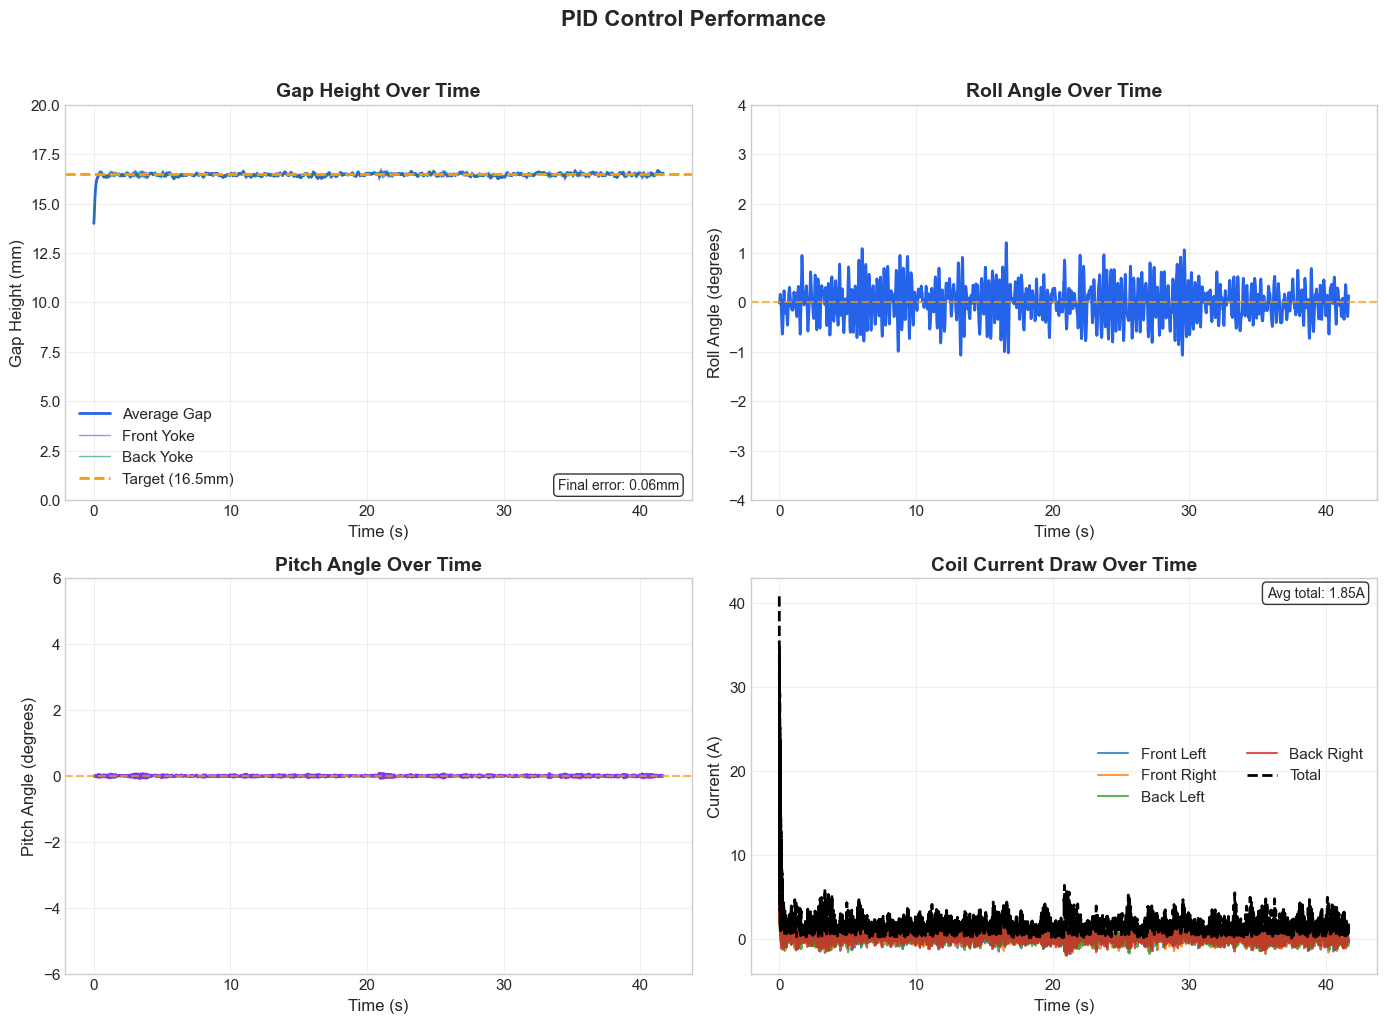

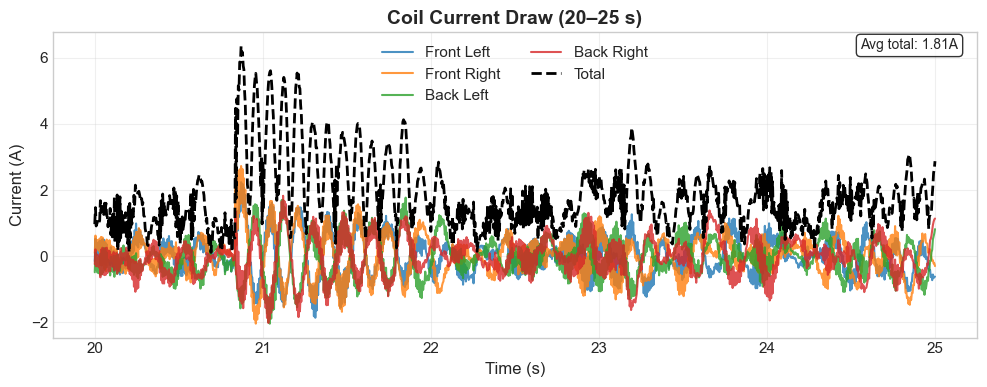

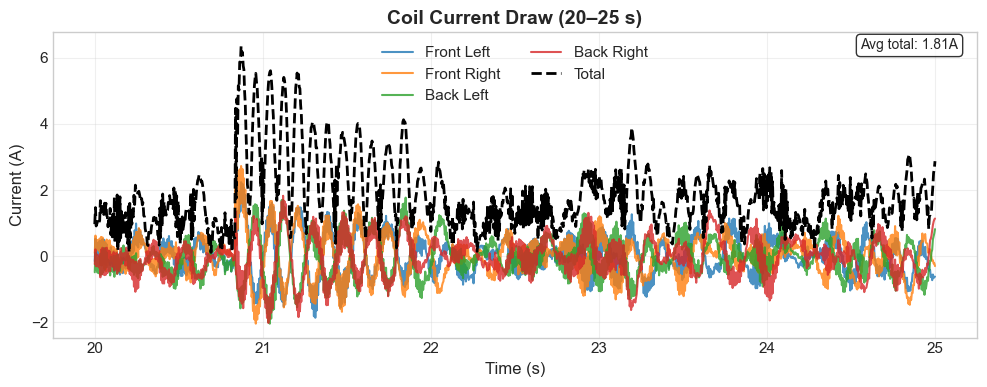

In [47]:
# Plot main performance metrics
plot_results(results)
show_current_slice(results, 20, 25)

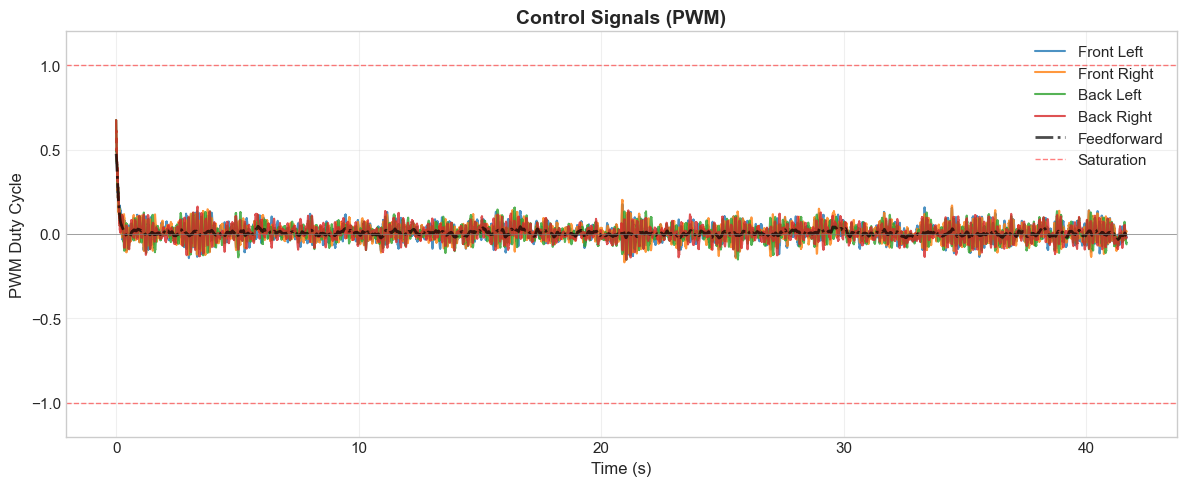

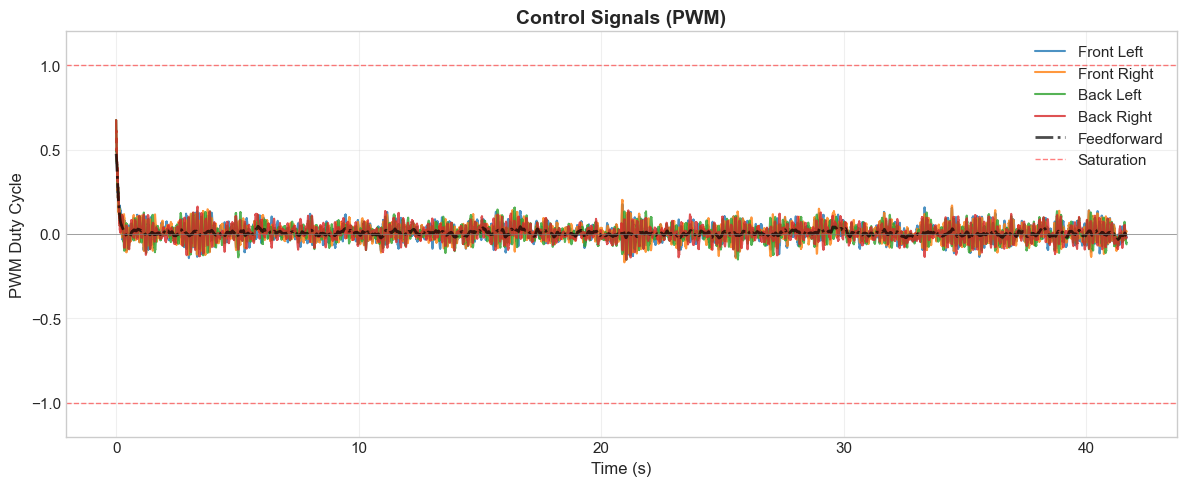

In [48]:
# Plot control signals (optional)
plot_control_signals(results)

---
## Compare Multiple Initial Conditions

Run this cell to test the controller with different starting heights.

In [49]:
def compare_initial_conditions(initial_gaps_mm: list, max_steps: int = 2000):
    """
    Compare PID performance across different initial conditions.
    
    Args:
        initial_gaps_mm: List of starting gap heights to test
        max_steps: Maximum steps per simulation
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('PID Performance Comparison: Different Initial Conditions', 
                 fontsize=16, fontweight='bold', y=1.02)
    
    target_gap_mm = TARGET_GAP * 1000
    colors = plt.cm.viridis(np.linspace(0, 0.8, len(initial_gaps_mm)))
    
    all_results = []
    
    for i, gap in enumerate(initial_gaps_mm):
        print(f"Running simulation {i+1}/{len(initial_gaps_mm)}: initial_gap={gap}mm")
        data = run_pid_simulation(initial_gap_mm=gap, max_steps=max_steps, gains=gains, verbose=False)
        all_results.append((gap, data))
        
        label = f'{gap}mm'
        
        # Gap height
        axes[0, 0].plot(data['time'], data['gap_avg'], color=colors[i], 
                        linewidth=2, label=label)
        
        # Roll
        axes[0, 1].plot(data['time'], data['roll_deg'], color=colors[i], 
                        linewidth=2, label=label)
        
        # Pitch
        axes[1, 0].plot(data['time'], data['pitch_deg'], color=colors[i], 
                        linewidth=2, label=label)
        
        # Total current
        axes[1, 1].plot(data['time'], data['current_total'], color=colors[i], 
                        linewidth=2, label=label)
    
    # Add target line to gap plot
    axes[0, 0].axhline(y=target_gap_mm, color='red', linestyle='--', 
                       linewidth=2, label=f'Target ({target_gap_mm:.1f}mm)')
    
    # Configure axes
    axes[0, 0].set_xlabel('Time (s)')
    axes[0, 0].set_ylabel('Gap Height (mm)')
    axes[0, 0].set_title('Average Gap Height', fontweight='bold')
    axes[0, 0].legend(loc='best')
    axes[0, 0].set_ylim([0, 20])
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].axhline(y=0, color='gray', linestyle='--', linewidth=1)
    axes[0, 1].set_xlabel('Time (s)')
    axes[0, 1].set_ylabel('Roll Angle (degrees)')
    axes[0, 1].set_title('Roll Angle', fontweight='bold')
    axes[0, 1].legend(loc='best')
    axes[0, 1].set_ylim([-4, 4])
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].axhline(y=0, color='gray', linestyle='--', linewidth=1)
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_ylabel('Pitch Angle (degrees)')
    axes[1, 0].set_title('Pitch Angle', fontweight='bold')
    axes[1, 0].legend(loc='best')
    axes[1, 0].set_ylim([-6, 6])
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].set_xlabel('Time (s)')
    axes[1, 1].set_ylabel('Total Current (A)')
    axes[1, 1].set_title('Total Current Draw', fontweight='bold')
    axes[1, 1].legend(loc='best')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return all_results

In [50]:
# Show simulation results data structure in a readable format
def show_data_structure(data: dict, name: str = "results", sample_rows: int = 3):
    """Print keys, shapes, dtypes, and a small sample of the simulation data dict."""
    print("=" * 60)
    print(f"Data structure: {name} (from run_pid_simulation)")
    print("=" * 60)
    n = len(data["time"]) if "time" in data else 0
    print(f"Number of time steps: {n}\n")
    print(f"{'Key':<18} {'Shape':<14} {'Dtype':<12} {'Min':<10} {'Max':<10}")
    print("-" * 60)
    for key in sorted(data.keys()):
        arr = data[key]
        if isinstance(arr, np.ndarray):
            sh = str(arr.shape)
            dt = str(arr.dtype)
            mn = f"{np.min(arr):.4g}" if arr.size else "—"
            mx = f"{np.max(arr):.4g}" if arr.size else "—"
        else:
            sh, dt, mn, mx = "—", "—", "—", "—"
        print(f"{key:<18} {sh:<14} {dt:<12} {mn:<10} {mx:<10}")
    print("-" * 60)
    print("\nSample (first and last time steps):")
    if n >= 1:
        sample_idx = [0, n // 2, n - 1] if n >= 3 else list(range(n))
        for i in sample_idx:
            t = data["time"][i]
            print(f"\n  Step {i}: t = {t:.4f} s")
            print(f"    gap_avg={data['gap_avg'][i]:.3f} mm  roll={data['roll_deg'][i]:.3f}°  pitch={data['pitch_deg'][i]:.3f}°")
            print(f"    pwm: FL={data['pwm_FL'][i]:.3f} FR={data['pwm_FR'][i]:.3f} BL={data['pwm_BL'][i]:.3f} BR={data['pwm_BR'][i]:.3f}")
            if "ff_pwm" in data:
                print(f"    ff_pwm={data['ff_pwm'][i]:.3f}  current_total={data['current_total'][i]:.3f} A")

show_data_structure(results, "results")

Data structure: results (from run_pid_simulation)
Number of time steps: 10000

Key                Shape          Dtype        Min        Max       
------------------------------------------------------------
current_BL         (10000,)       float64      -2.039     10.2      
current_BR         (10000,)       float64      -2.018     10.2      
current_FL         (10000,)       float64      -1.859     10.2      
current_FR         (10000,)       float64      -2.037     10.2      
current_total      (10000,)       float64      0.0448     40.8      
ff_pwm             (10000,)       float64      -0.0345    0.4747    
gap_avg            (10000,)       float64      14         16.67     
gap_back           (10000,)       float64      14         16.77     
gap_front          (10000,)       float64      14         16.74     
pitch_deg          (10000,)       float64      -0.08188   0.08608   
pwm_BL             (10000,)       float32      -0.1535    0.6741    
pwm_BR             (10000,)     

In [51]:
# Compare different starting heights
# Uncomment and run to test multiple initial conditions

# comparison_results = compare_initial_conditions(
#     initial_gaps_mm=[10.0, 14.0, 18.0, 22.0],
#     max_steps=2000
# )

---
## PID Tuning with Optuna

Bayesian-style optimization (Optuna TPE sampler) tunes all **nine** gains (height, roll, pitch × Kp, Ki, Kd) **jointly** so loop coupling is respected.

- **Run optimizer** (script or cell below): saves `pid_best_params.json` in this folder.
- **Use new params**: re-run the **Load PID gains** cell at the top, then the **PID Gains** cell and the simulation.

In [52]:
# Option A: Run Optuna optimization (slow). Saves pid_best_params.json next to optuna_pid_tune.py.
# from optuna_pid_tune import run_optimization
# study = run_optimization(n_trials=50, timeout=1800)
# print("Best:", study.best_params)

# After running Optuna: re-run the "Load PID gains" cell at the top of the notebook
# to pick up the new pid_best_params.json, then re-run the PID Gains cell and the simulation.

---
## Test Disturbance Rejection

Apply a sudden force disturbance and observe recovery.

In [53]:
# Test disturbance rejection
# Uncomment and run to test disturbance response

# Example 1: Impulse disturbance (one-time force)
# disturbance_results = run_pid_simulation(
#     initial_gap_mm=16.5,         # Start near target
#     max_steps=3000,
#     use_gui=False,
#     disturbance_step=720,        # Apply at 3 seconds
#     disturbance_force=-20.0,     # 20N downward push
#     verbose=True
# )
# plot_results(disturbance_results, title_suffix=' (with 20N impulse at t=3s)')

# Example 2: Continuous stochastic noise
# noisy_results = run_pid_simulation(
#     initial_gap_mm=16.5,
#     max_steps=3000,
#     use_gui=False,
#     disturbance_force_std=2.0,   # 2N standard deviation continuous noise
#     verbose=True
# )
# plot_results(noisy_results, title_suffix=' (with 2N std continuous noise)')

---
## Summary Statistics

In [54]:
def print_summary(data: dict):
    """Print summary statistics for a simulation run."""
    target_gap_mm = TARGET_GAP * 1000
    
    # Calculate settling time (within 2% of target)
    tolerance = 0.02 * target_gap_mm
    settled_idx = None
    for i in range(len(data['gap_avg'])):
        if abs(data['gap_avg'][i] - target_gap_mm) < tolerance:
            # Check if it stays settled
            if all(abs(data['gap_avg'][j] - target_gap_mm) < tolerance 
                   for j in range(i, min(i+100, len(data['gap_avg'])))):
                settled_idx = i
                break
    
    print("=" * 50)
    print("SIMULATION SUMMARY")
    print("=" * 50)
    print(f"Duration: {data['time'][-1]:.2f} seconds ({len(data['time'])} steps)")
    print(f"Target gap: {target_gap_mm:.2f} mm")
    print()
    print("Gap Height:")
    print(f"  Initial:  {data['gap_avg'][0]:.2f} mm")
    print(f"  Final:    {data['gap_avg'][-1]:.2f} mm")
    print(f"  Error:    {abs(data['gap_avg'][-1] - target_gap_mm):.3f} mm")
    print(f"  Max:      {max(data['gap_avg']):.2f} mm")
    print(f"  Min:      {min(data['gap_avg']):.2f} mm")
    if settled_idx:
        print(f"  Settling time (2%): {data['time'][settled_idx]:.3f} s")
    else:
        print(f"  Settling time: Not settled within tolerance")
    print()
    print("Orientation (final):")
    print(f"  Roll:  {data['roll_deg'][-1]:+.3f} degrees")
    print(f"  Pitch: {data['pitch_deg'][-1]:+.3f} degrees")
    print()
    print("Current Draw:")
    print(f"  Average total: {np.mean(data['current_total']):.2f} A")
    print(f"  Peak total:    {max(data['current_total']):.2f} A")
    print("=" * 50)

# Print summary for last simulation
print_summary(results)

SIMULATION SUMMARY
Duration: 41.66 seconds (10000 steps)
Target gap: 16.49 mm

Gap Height:
  Initial:  14.00 mm
  Final:    16.55 mm
  Error:    0.056 mm
  Max:      16.67 mm
  Min:      14.00 mm
  Settling time (2%): 0.196 s

Orientation (final):
  Roll:  +0.137 degrees
  Pitch: +0.011 degrees

Current Draw:
  Average total: 1.85 A
  Peak total:    40.80 A
